In [1]:
import os
import seaborn as sns
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

# hbn-specific libraries - make sure you have installed (pipenv install) and activated (pipenv shell) 
# the virtual environment for this project, and make sure you have created an ipykernel for this environment (ipython kernel install --name "hbn" --user)
from hbn.constants import Defaults
from hbn.scripts import preprocess_phenotype, make_phenotype_specs
from hbn.data import make_dataset
from hbn.features.feature_selection import phenotype_features

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## Child Behavior Checklist - Parent and Teacher Reports
### separated by preschool and school aged children

### Relevent dictionaries (in `Release9_DataDic` folder)
* CBCL_Pre (Preschool - Parent Report)
* CBCL (School-aged - Parent Report)
* TRF_P (Preschool - Teacher Report)
* TRF (School-aged - Teacher Report)

In [2]:
# RUN THIS CELL
# FUNCTIONS

def get_data(
    participants, 
    feature_spec, 
    cols_to_keep=['DX_01', 'DX_01_Cat', 'Age', 'Sex', 'Identifiers']
    ):
    # get data
    df = phenotype_features(
                            target_spec=None,
                            feature_spec=os.path.join(Defaults.FEATURE_DIR, feature_spec),
                            participants=participants,
                            preprocess=False,
                            drop_identifiers=False
                            )

    # get summary of clinical diagnosis + other demographics
    dx = make_dataset.make_summary(save=False)
    dx = make_dataset._add_race_ethnicity(dataframe=dx)

    # get data from intake interview and merge with clinical summary
    df = df.merge(dx[cols_to_keep], on='Identifiers')
    
    return df

def get_full_dataframe(
    spec_info,
    participants,
    cols_to_keep='Identifiers|DX_01|Age|Sex|DX_01_Cat',
    filter_scores=True,
    ):

    df_all = pd.DataFrame()
    for info in spec_info:
        # get data
        df = get_data(participants, 
                     feature_spec=info['feature_spec'],
                     cols_to_keep=list(cols_to_keep.split('|'))
                     )
        abbrev = info['code'][0]

        # load data dictionary
        dict_df = pd.read_excel(os.path.join(Defaults.PHENO_DIR, 'Release9_DataDic', abbrev.replace(',','') + '.xlsx'), header=1) 

        # remove prefix from variable values - always second column in data dic
        dict_df.rename(columns={dict_df.columns[0]: "Question", dict_df.columns[1]: "Variable"}, inplace=True)
        dict_df['Variable'] = dict_df['Variable'].str.replace(abbrev.replace(',','_'), '')

        # filter dataframe on certain columns and regex patterns
        df_filter = df.filter(regex=f'{abbrev}|{cols_to_keep}')

        # loop over diagnosis groups and melt `T_scores` column into one
        # concat each group to one dataframe
        for name, group in df_filter.groupby('DX_01'):
            group.columns = group.columns.str.replace(info['code'][1],'')
            if filter_scores:
                group = group.filter(regex=f'_T|{cols_to_keep}')
            tmp = group.melt(id_vars=list(cols_to_keep.split('|'))).rename({'variable':'T_name', 'value': 'T_scores'}, axis=1)
            tmp = tmp.merge(dict_df[['Question', 'Variable']], left_on=['T_name'], right_on=['Variable'])
            tmp['Assessment'] = info['Assessment']
            tmp['Preschool'] = info['Preschool']
            df_all = pd.concat([tmp, df_all])

    # do some clean up on existing columns
    #df_all['T_name'] = df_all['T_name'].str.rstrip('.1') # remove .1 from end of variable names
    df_all['Age_rounded'] = df_all['Age'].round()
    df_all['Question'] = df_all['Question'].str.replace("T Score", "T-Score")
    
    return df_all.reset_index(drop=True)


In [3]:
## RUN THIS CELL ##

# Preprocess data
#preprocess_phenotype.run()

# get specs
#make_phenotype_specs.run()


# INPUTS
participants = make_dataset.get_participants(
                            split='all', 
                            disorders=['ADHD-Combined Type', 
                                        'ADHD-Inattentive Type', 
                                        'ADHD-Hyperactive_Impulsive_Type', 
                                        'Other_Specified_Attention-Deficit_Hyperactivity_Disorder',
                                        'No_Diagnosis_Given']
                                        )



spec_info = [
    {'Assessment': 'Parent',
    'code': ['CBCL,', 'CBCL,CBCL_'],
     'Preschool': False,
     'feature_spec': 'features-Parent_Measures-Demographic_Questionnaire_Measures-Child_Behavior_Checklist-spec.json'
    }, 
    {'Assessment': 'Parent',
     'code': ['CBCL_Pre,','CBCL_Pre,CBCLPre_'],
     'Preschool': True,
     'feature_spec': 'features-Parent_Measures-Demographic_Questionnaire_Measures-Child_Behavior_Checklist-spec.json'
    },
    {'Assessment': 'Teacher',
     'code': ['TRF,','TRF,TRF_'],
     'Preschool': False,
     'feature_spec': 'features-Teacher_Measures-Child_Behavior_Checklist_–_Teacher_Report_Form-Child_Behavior_Checklist_–_Teacher_Report_Form-spec.json'
    },
    {'Assessment': 'Teacher',
    'code': ['TRF_P,', 'TRF_P,TRF_P_'],
    'Preschool': True,
    'feature_spec': 'features-Teacher_Measures-Child_Behavior_Checklist_–_Teacher_Report_Form-Child_Behavior_Checklist_–_Teacher_Report_Form-spec.json'
    }
    ]

df = get_full_dataframe(
                    spec_info=spec_info,
                    participants=participants,
                    cols_to_keep='Identifiers|DX_01|Age|Sex|DX_01_Cat',
                    filter_scores=True,
                    )


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## General Summary - T-Scores (Total Scores - Scaled)
### Presented as barplots and radar plots (note that these plots don't display error bars)


* Teachers give lower T scores than parents, which means that parents rate their children as having more behavioral problems
* The difference in T scores given by parent and teachers is most prominent in inattentive and combined ADHD types.
    * These differences are similar across males and females
    * These differences are only noticeable when children start attending school (i.e. no differences in parent/teacher reporting in preschoolers)
* There are notable differences in T scores between children without a Diagnosis of ADHD ("No Diagnosis Given") and children with ADHD, the former have lower T scores
* there is a slight decrease in T scores across development, but only for ADHD group

Text(0.5, 1.0, 'All Participants')

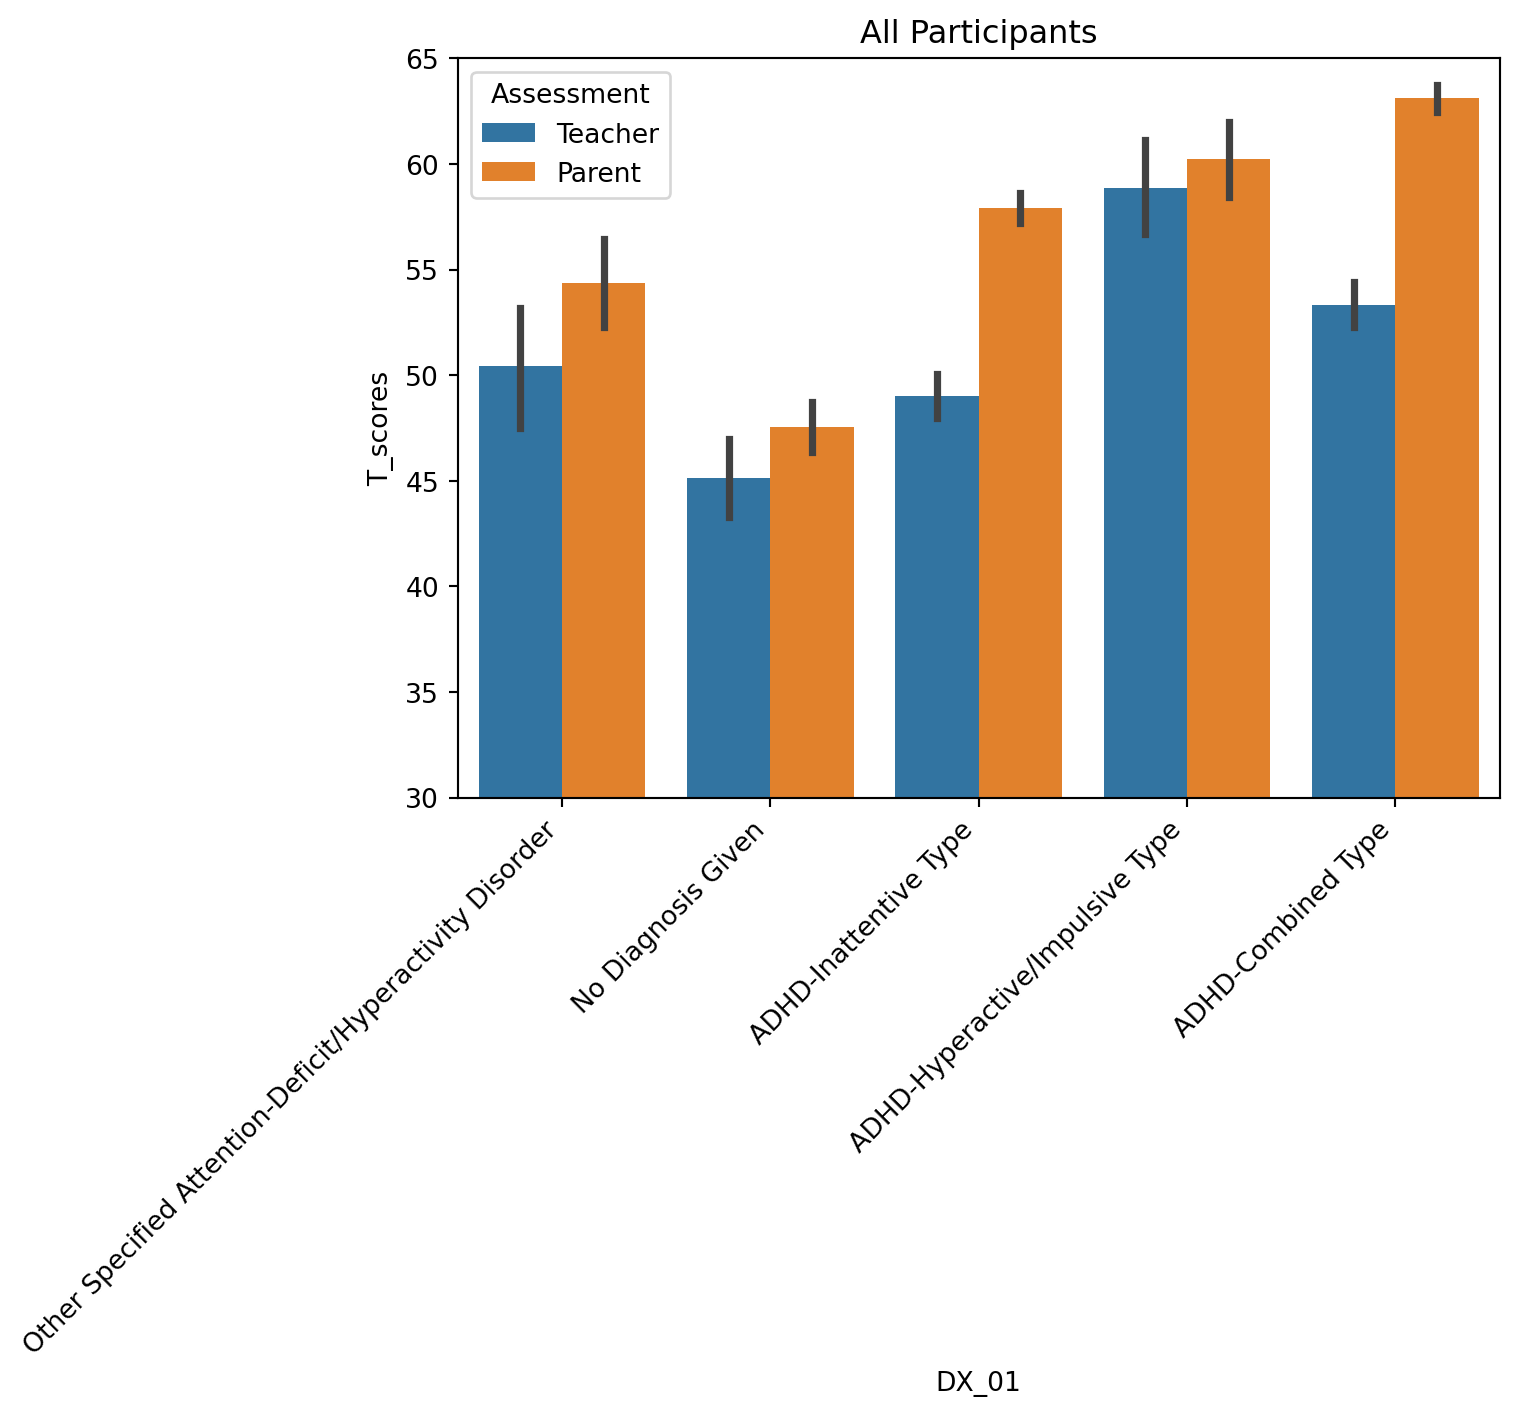

In [4]:
tmp = df[df['T_name']=='Total_T']

sns.barplot(data=tmp, x='DX_01', y='T_scores', hue='Assessment')
plt.xticks(rotation=45, ha='right');
plt.ylim([30,65])
plt.title('All Participants')

In [5]:
tmp = df[df['T_name']=='Total_T']

tmp = tmp.groupby(['DX_01', 'Assessment']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="DX_01", color="Assessment", line_close=True, range_r=[50,64])
fig.show()

## Across all ages, participants with neurodevelopmental disorders (i.e. ADHD) have higher T scores than participants without a diagnosis

Text(0.5, 1.0, 'All Participants')

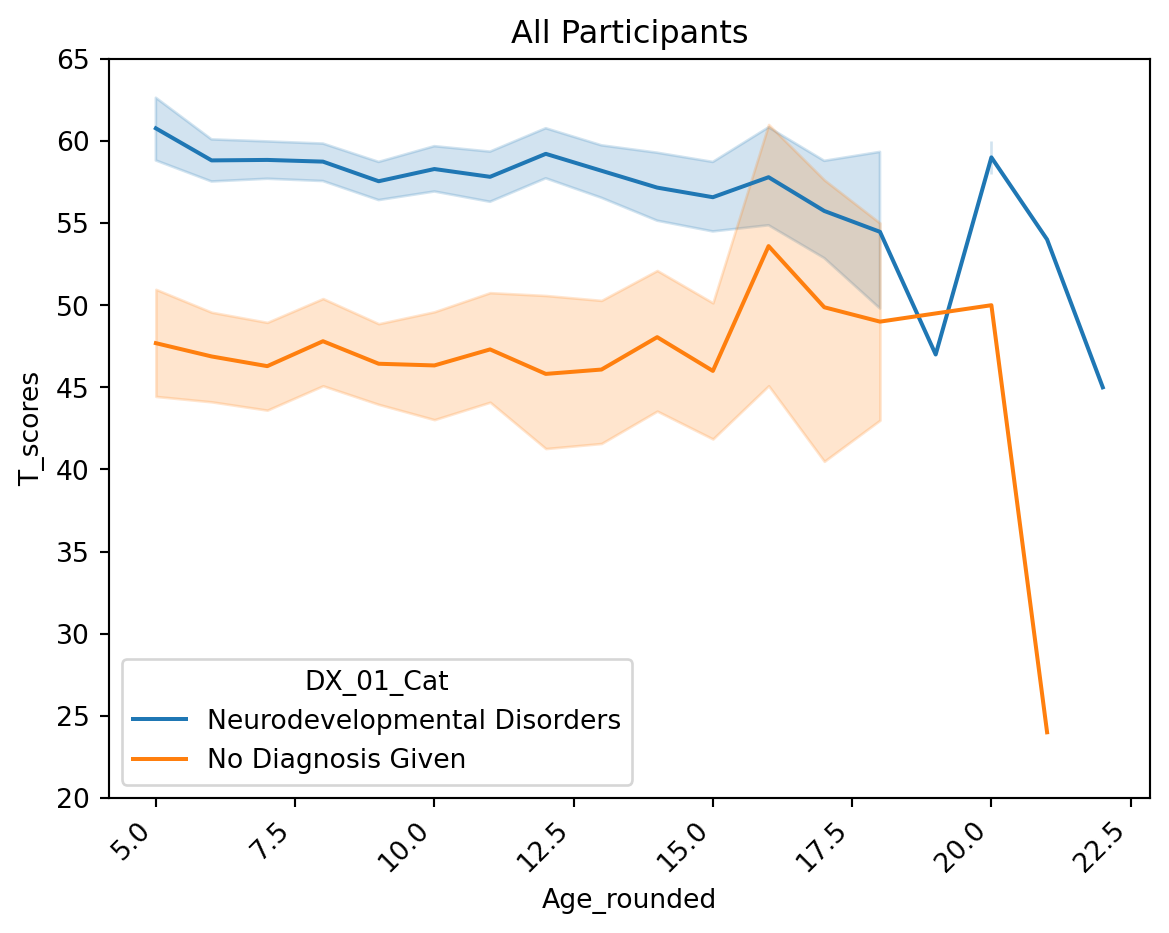

In [6]:
tmp = df[df['T_name']=='Total_T']

sns.lineplot(data=tmp, x='Age_rounded', y='T_scores', hue='DX_01_Cat')
plt.xticks(rotation=45, ha='right');
plt.ylim([20,65])
plt.title('All Participants')

## For female participants, teacher and parent differences are similar to group

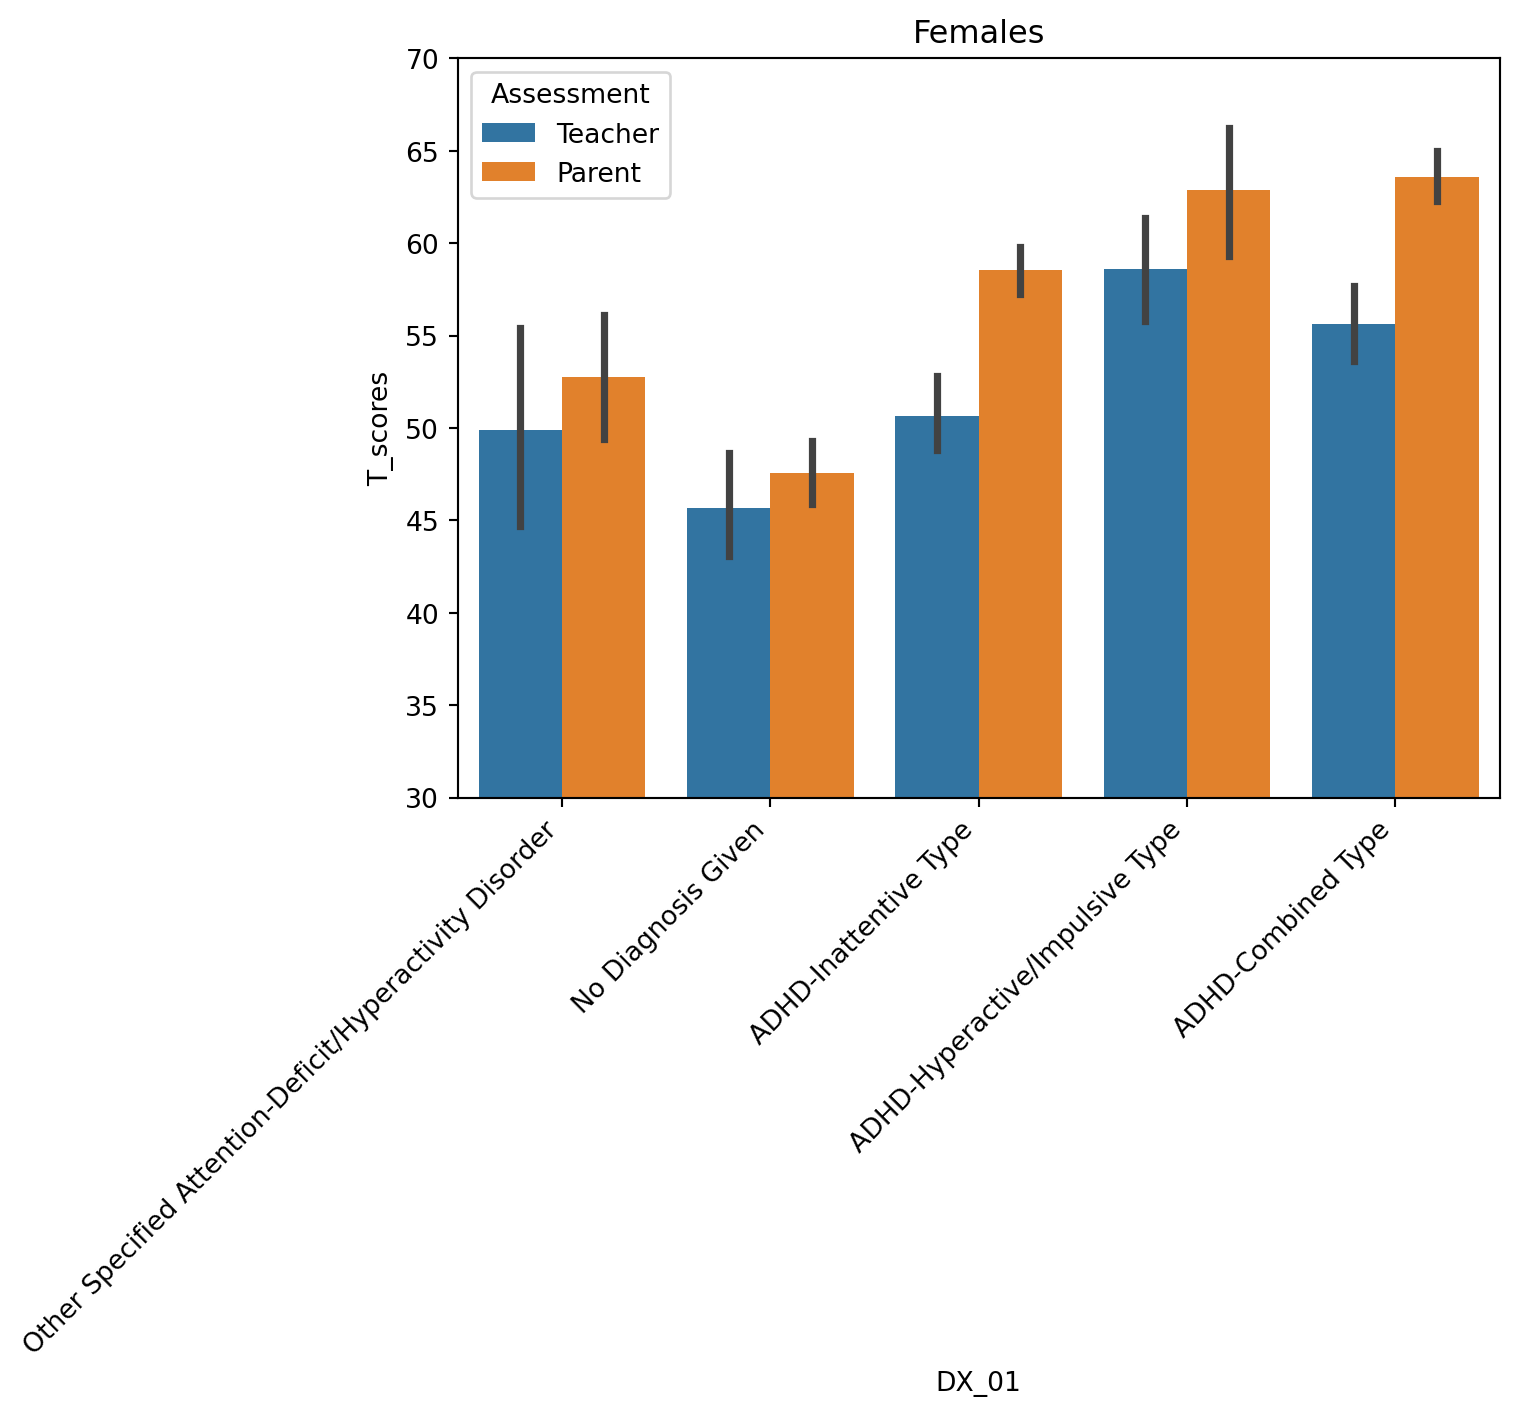

In [7]:
tmp = df[(df['T_name']=='Total_T') & (df['Sex']=='female')]

sns.barplot(data=tmp, x='DX_01', y='T_scores', hue='Assessment')
plt.xticks(rotation=45, ha='right');
plt.ylim([30,70])
plt.title('Females');

In [8]:
tmp = df[(df['T_name']=='Total_T') & (df['Sex']=='female')]

tmp = tmp.groupby(['DX_01', 'Assessment']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="DX_01", color="Assessment", line_close=True, range_r=[50,64])
fig.show()

## For male participants, teacher and parent differences are similar to group

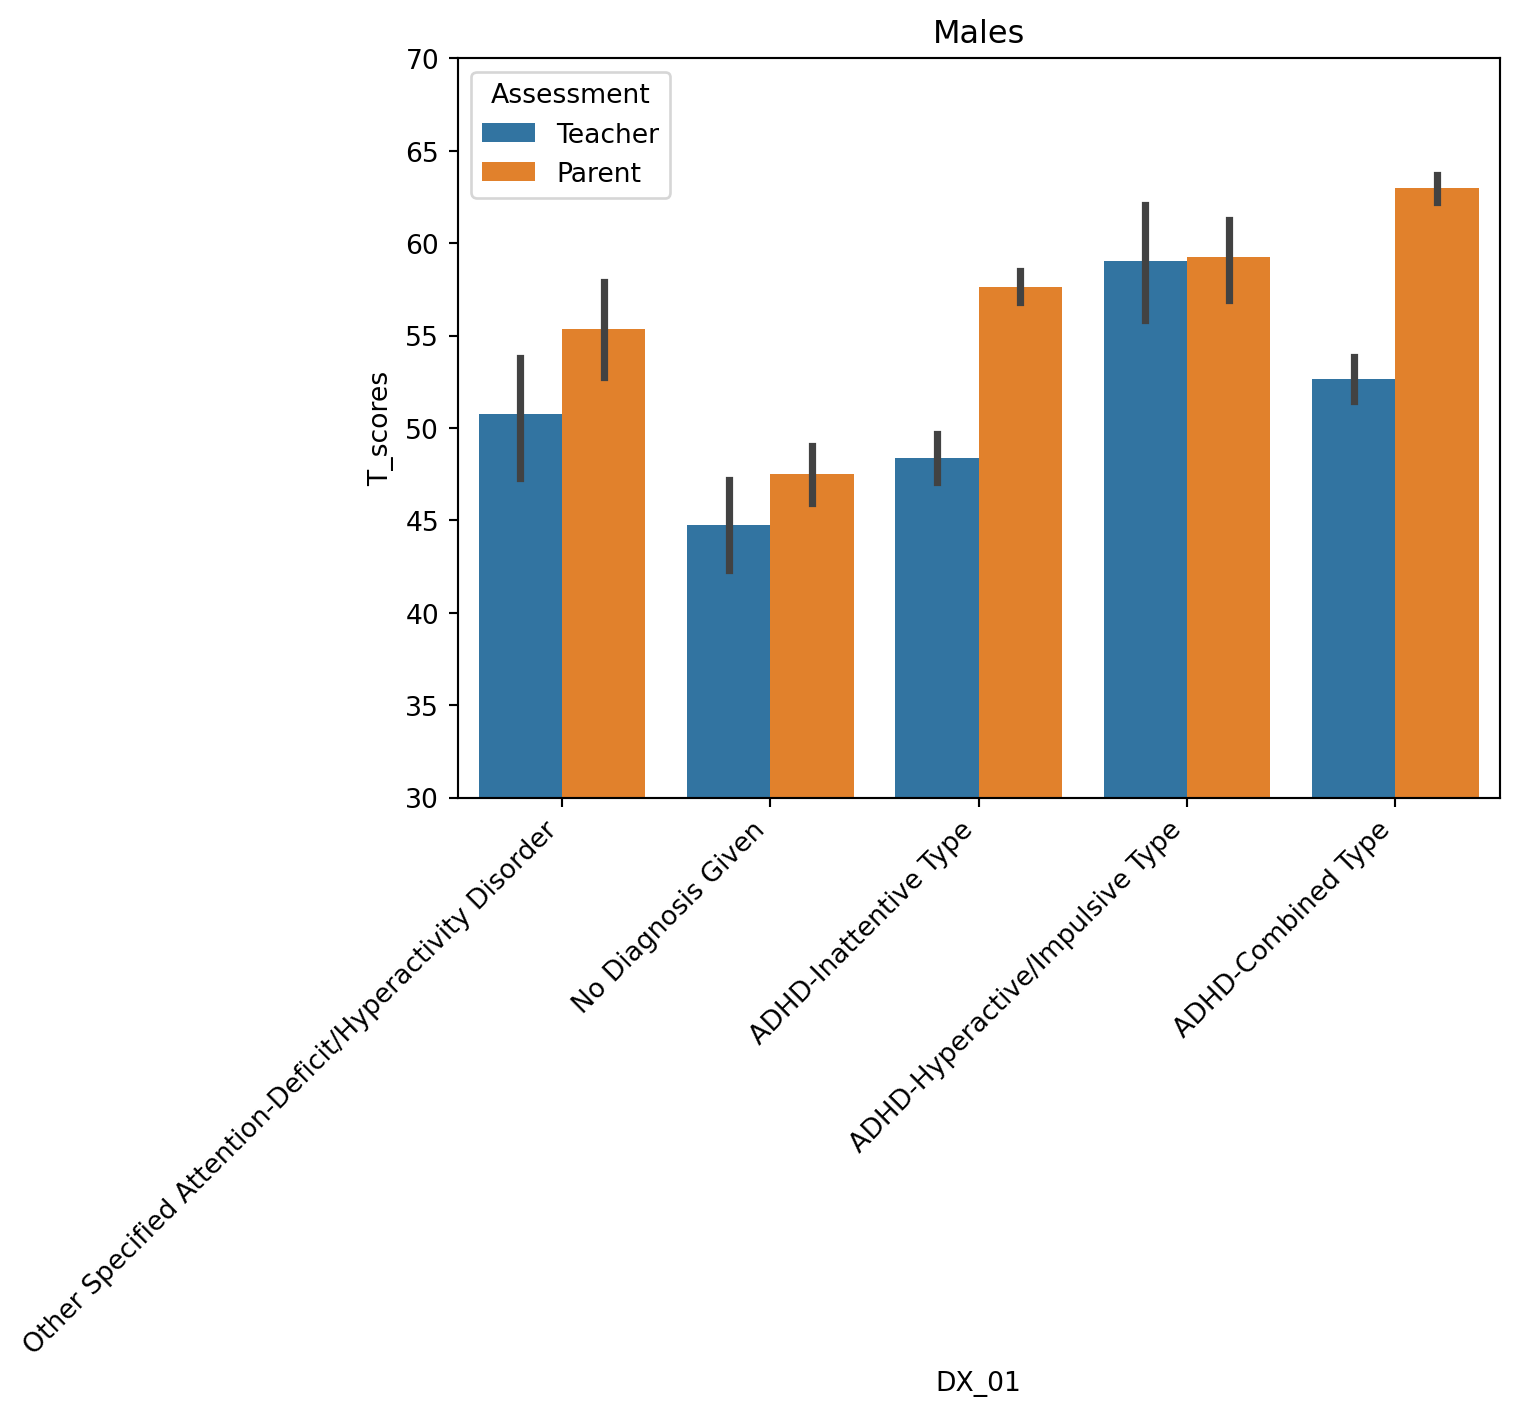

In [9]:
tmp = df[(df['T_name']=='Total_T') & (df['Sex']=='male')]

sns.barplot(data=tmp, x='DX_01', y='T_scores', hue='Assessment')
plt.xticks(rotation=45, ha='right');
plt.ylim([30,70])
plt.title('Males');

In [10]:
tmp = df[(df['T_name']=='Total_T') & (df['Sex']=='male')]

tmp = tmp.groupby(['DX_01', 'Assessment']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="DX_01", color="Assessment", line_close=True, range_r=[50,64])
fig.show()

## Only notable difference between teacher and parent reports for preschoolers is in "Other Specified/ADHD" subtype -- parents rate their children as having more behavioral problems than teachers (ADHD inattentive has too few participants to make an inference)

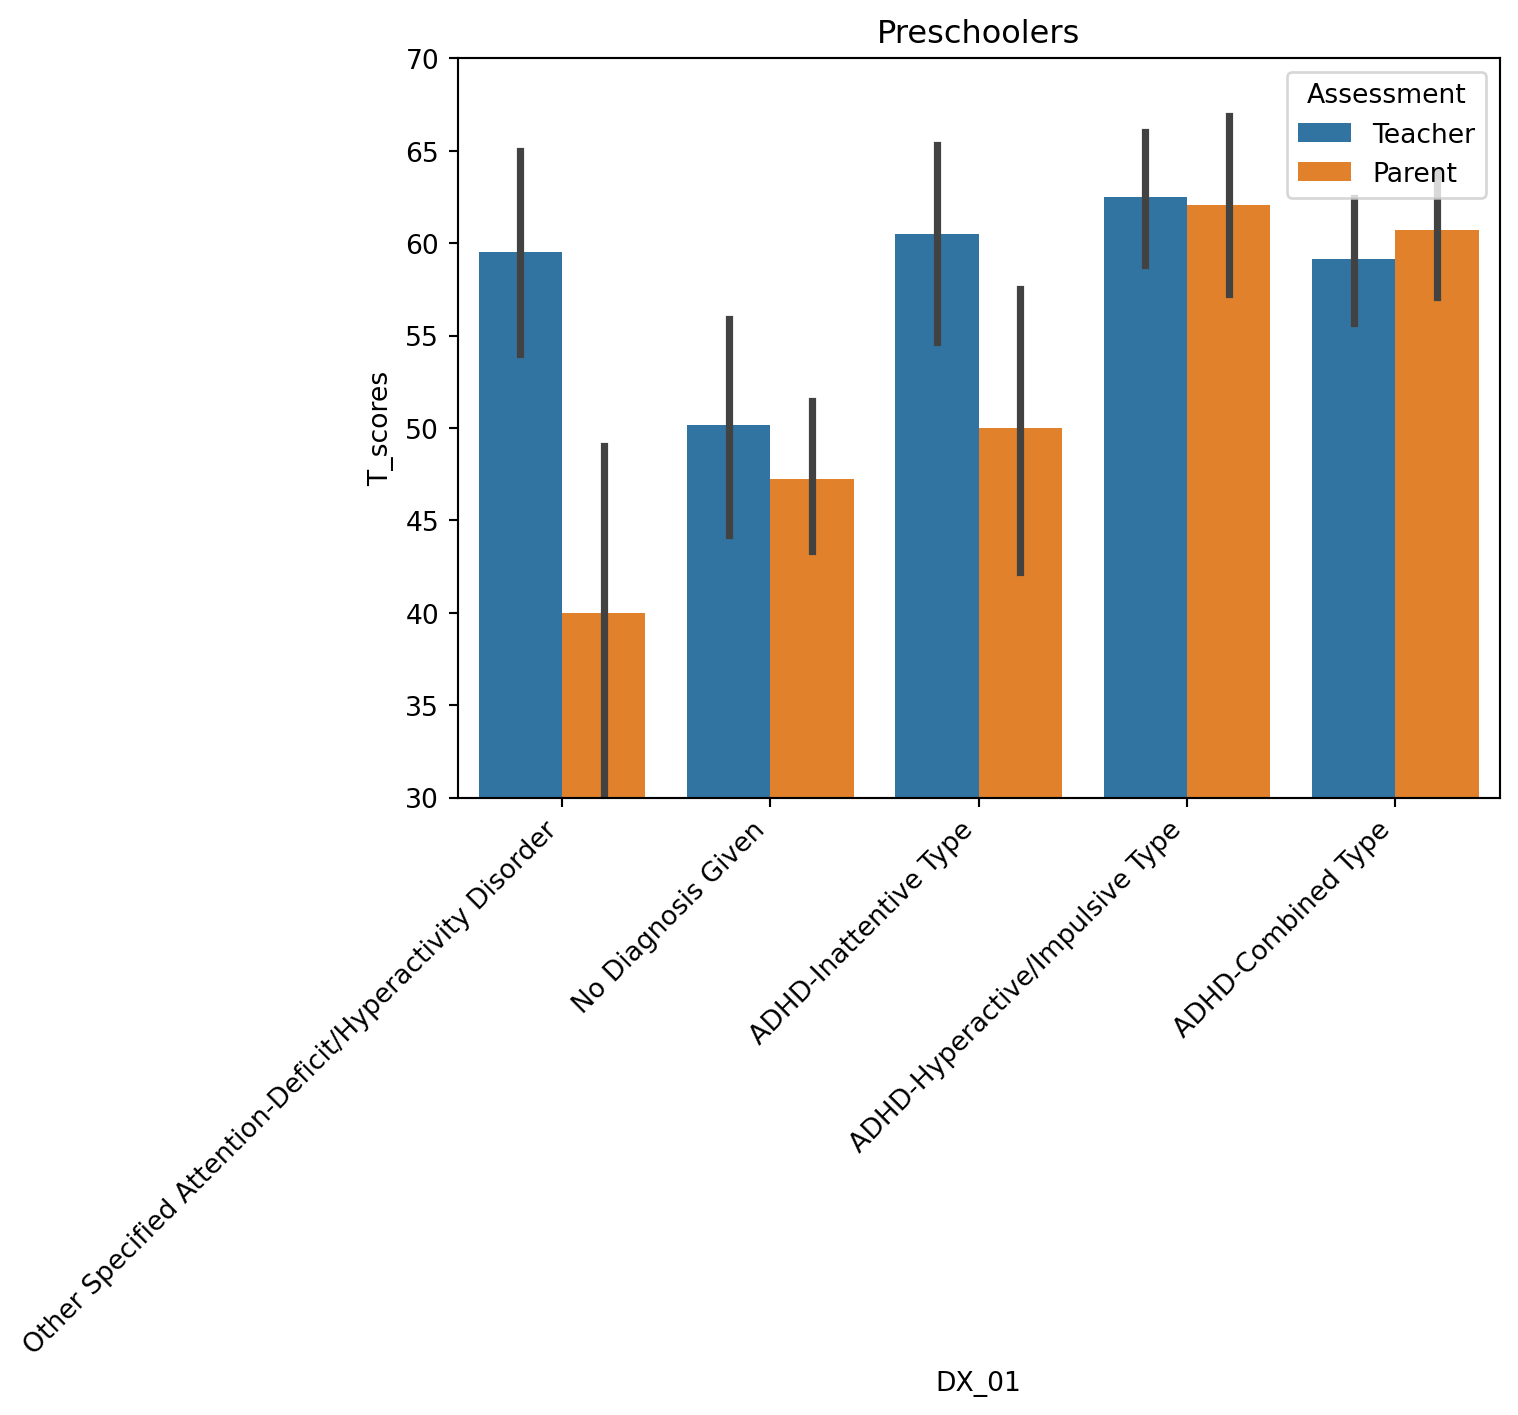

In [11]:
tmp = df[(df['T_name']=='Total_T') & (df['Preschool']==True)]

sns.barplot(data=tmp, x='DX_01', y='T_scores', hue='Assessment')
plt.xticks(rotation=45, ha='right');
plt.ylim([30,70])
plt.title('Preschoolers');

In [12]:
tmp = df[(df['T_name']=='Total_T') & (df['Preschool']==True)]

tmp = tmp.groupby(['DX_01', 'Assessment']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="DX_01", color="Assessment", line_close=True, range_r=[50,64])
fig.show()

## Preschoolers with hyperactive/impulsive subtype are rated as having more behavioral problems than their older counterparts

In [13]:
tmp = df[(df['T_name']=='Total_T')]
tmp['Preschool_cat'] = tmp['Preschool'].map({True: 'Preschool', False: 'Elementary/Middle School'})

tmp = tmp.groupby(['DX_01', 'Preschool_cat']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="DX_01", color="Preschool_cat", line_close=True, range_r=[50,64])
fig.show()

## T scores across all participants 

In [14]:
tmp = df[(df['T_name']=='Total_T')]

fig = px.scatter(tmp, x="Identifiers", y="T_scores", color="DX_01",
                hover_name="DX_01", log_x=False, size_max=60) # size="Age"
fig.update_layout(showlegend=False)
fig.update_xaxes(showticklabels=False, title='Participants')
fig.show()

## T scores for male and female participants with ADHD

In [15]:
tmp = df[(df['T_name']=='Total_T') & (df['DX_01_Cat']=='Neurodevelopmental Disorders')]

fig = px.scatter(tmp, x="Identifiers", y="T_scores", color="Sex",
                hover_name="Sex", log_x=False, size_max=60) # size="Age"
fig.update_layout(showlegend=False)
fig.update_xaxes(showticklabels=False, title='Participants')
fig.show()

## General Summary - DSM Scores
### Children with neurodevelopmental disorders (i.e. ADHD diagnoses) have on average higher T scores on all DSM categories

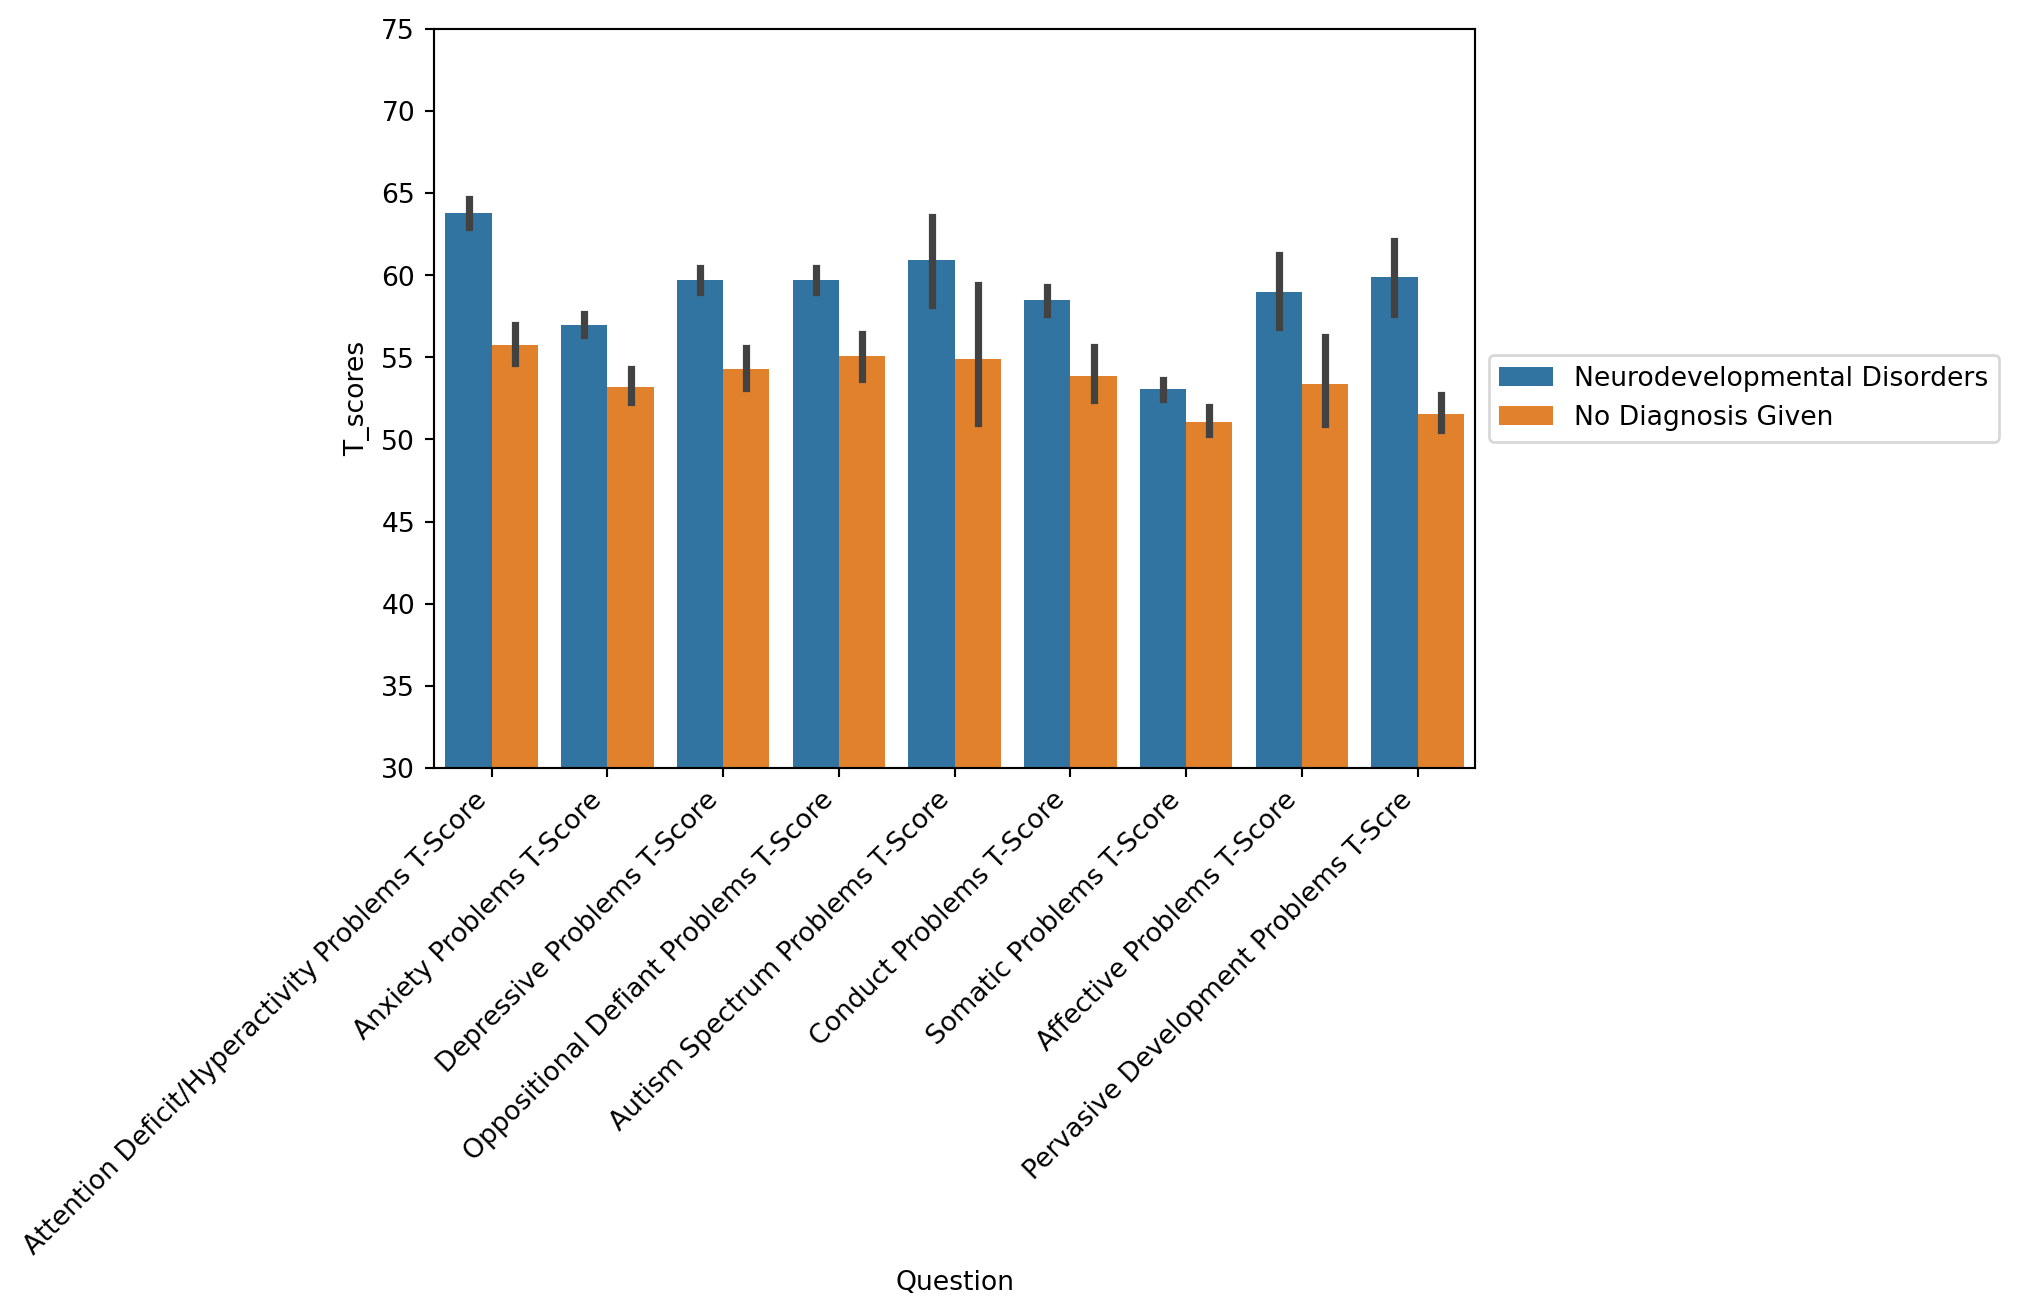

In [16]:
tmp = df[df['T_name'].str.find('DSM')==0]


sns.barplot(data=tmp, x='Question', y='T_scores', hue='DX_01_Cat')
plt.xticks(rotation=45, ha='right');
plt.ylim([30,75])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('');

## General Sumary - Syndrome Scale Scores
### Children with neurodevelopmental disorders (i.e. ADHD diagnoses) have on average higher T scores on all Syndrome Scales

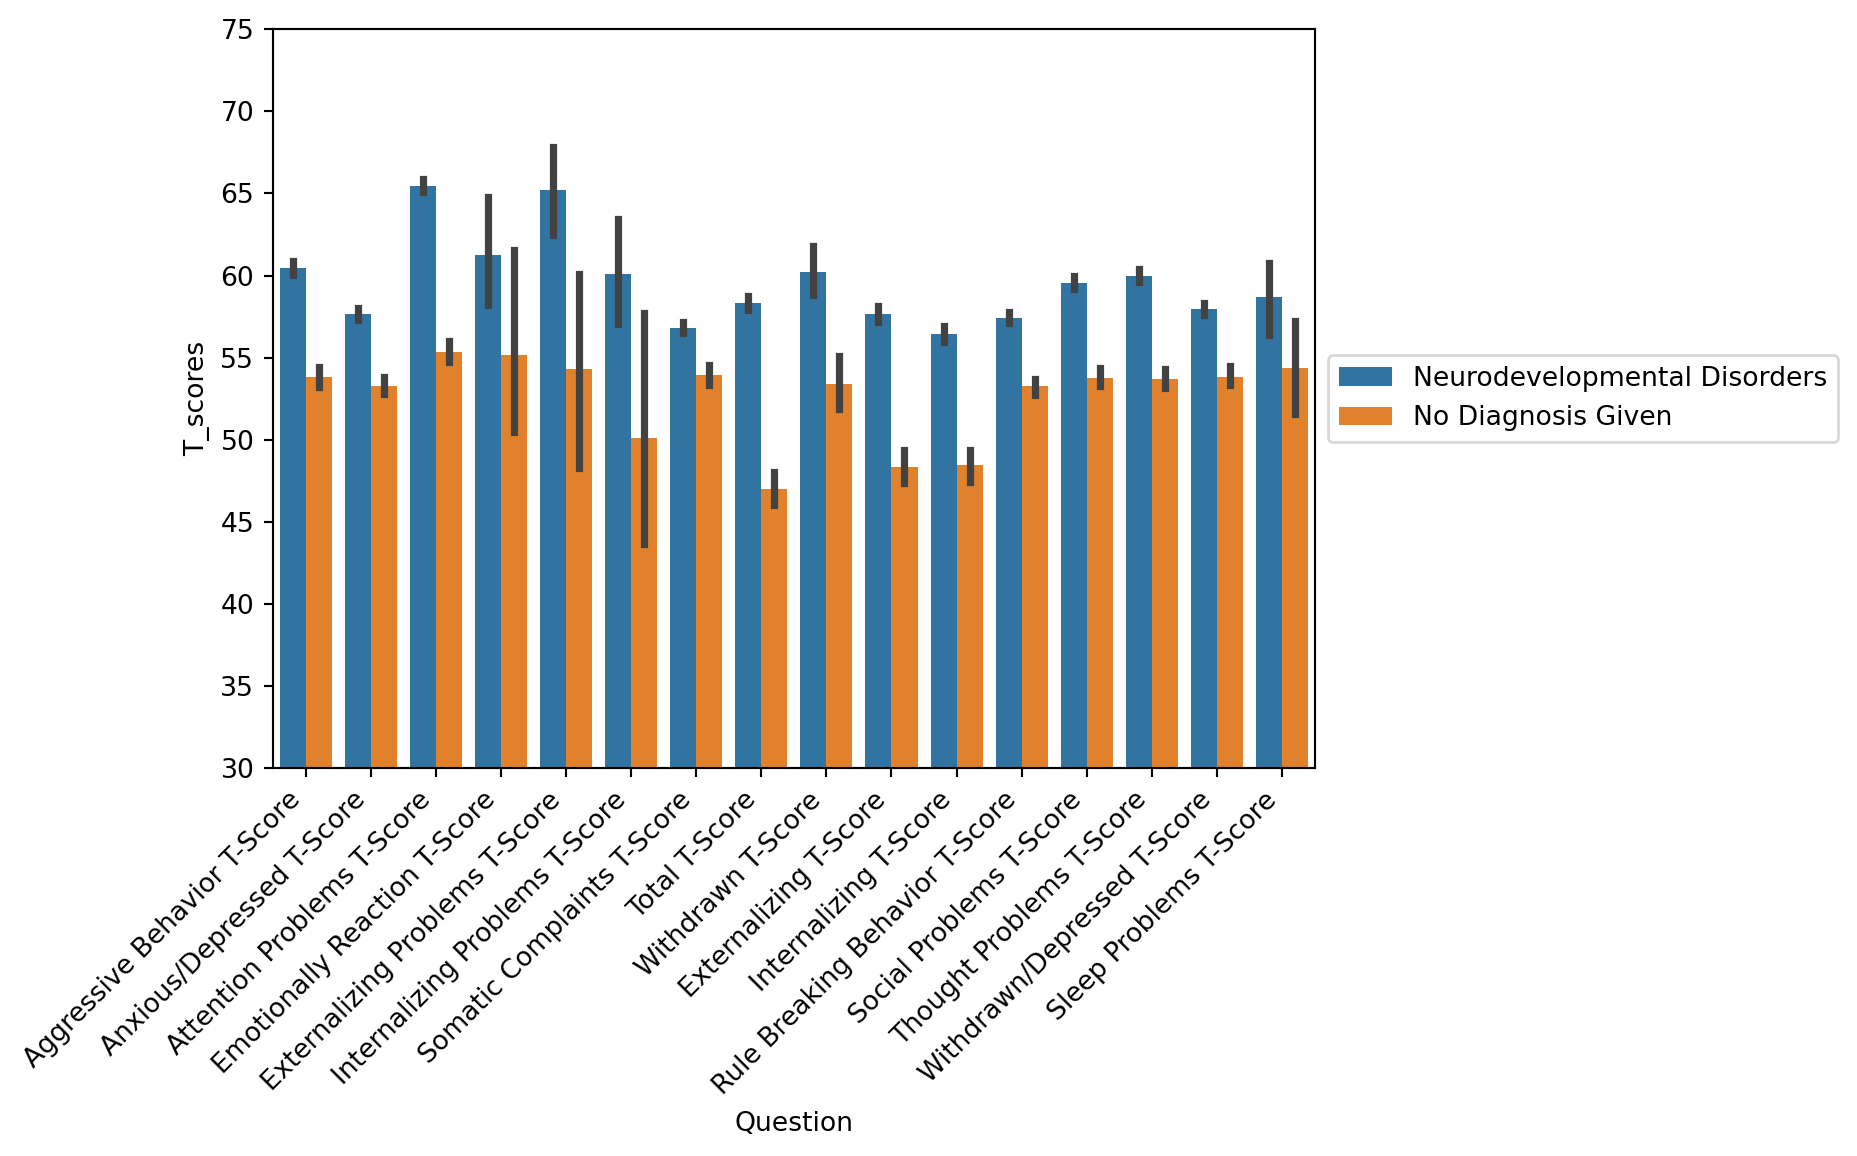

In [17]:
tmp = df[df['T_name'].str.find('DSM')==-1]

sns.barplot(data=tmp, x='Question', y='T_scores', hue='DX_01_Cat')
plt.xticks(rotation=45, ha='right');
plt.ylim([30,75])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('');

## Radar Plots - another way of visualizing the barplots
### error bars aren't represented here - these are average scores

In [18]:
tmp = df[df['T_name'].str.find('DSM')==-1]

tmp = tmp.groupby(['DX_01_Cat', 'Question']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="Question", color="DX_01_Cat", line_close=True, range_r=[50,68])
fig.show()


In [19]:
tmp = df[df['T_name'].str.find('DSM')==0]

tmp = tmp.groupby(['DX_01_Cat', 'Question']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="Question", color="DX_01_Cat", line_close=True, range_r=[50,65])
fig.show()


## Children with Hyperactive/Impulsive subtype have highest scores on 5 DSM measures:  oppositional defiant problems, conduct problems, developmental problems, depressive problems, and anxiety)

Multivariate information for ADHD subtypes and T Scores is plotted here using radar plots -- too much information to plot on a barplot


 

In [20]:
tmp = df[(df['T_name'].str.find('DSM')==0)]

tmp = tmp.groupby(['DX_01', 'Question']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="Question", color="DX_01", line_close=True, range_r=[50,70])
fig.show()

## Syndrome Scale scores across ADHD subtypes
* Children with inattentive type have highest scores on the following measures: withdrawn, emotional reaction, internalizing problems
* Children with Combined type have highest scores on the following measures (followed closely by hyperactive/impulsive type): rule breaking, sleep problems, social problems, somatic complaints, thought problems, attention problems

In [21]:
tmp = df[(df['T_name'].str.find('DSM')==-1)]

tmp = tmp.groupby(['DX_01', 'Question']).mean().reset_index()

fig = px.line_polar(tmp, r="T_scores", theta="Question", color="DX_01", line_close=True, range_r=[50,70])
fig.show()

## DSM scores across M/F for each ADHD subtype
* Girls with adhd combined type have higher scores on 7/9 measures, particularly on affective and ADHD scores
* Boys with hyperactive/impulsive adhd have higher scores than girls on almost all measures
* Boys with inattentive adhd have higher ASD scores, and other scores are roughly similar across M and F
* Children with no diagnoses have roughly similar scores on all measures, except that girls have higher scores on affective problems
* Girls with other specified attention-deficit/ADHD subtype have sig. higher ASD problems score

In [22]:
tmp = df[(df['T_name'].str.find('DSM')==0)]

for name, group in tmp.groupby('DX_01'):
    group = group.groupby(['Question', 'Sex']).mean().reset_index()
    fig = px.line_polar(group, r="T_scores", theta="Question", color="Sex", line_close=True, range_r=[50,75], title=name)
    fig.show()

## Syndrome Scale Scores across M/F for each ADHD subtype
* girls with adhd combined type have hgiher scores on attention problems and sleep problems
* boys with hyperactive type have higher scores on externalizing and internalizing problems
* boys with inattentive type have higher scores on emotional reaction and internalizing problems
* girls with other specified/hyperactive type have higher scores on externalizing and internalizing problems

In [23]:
tmp = df[(df['T_name'].str.find('DSM')==-1)]

for name, group in tmp.groupby('DX_01'):
    group = group.groupby(['Question', 'Sex']).mean().reset_index()
    fig = px.line_polar(group, r="T_scores", theta="Question", color="Sex", line_close=True, range_r=[50,75], title=name)
    fig.show()

## Specific Questions of Interest from Child Behavior Checklist
### Are there specific items from the CBCL (Preschool or Older; Teacher or Parent) that we want to investigate?